# Load Data

In [ ]:
import os
import numpy as np
from sklearn.model_selection import train_test_split

# folder_path = '../genriflow_data/'
folder_path = r'C:\Users\npapaniko\OneDrive\Music'

mp3_master = [f for f in os.listdir(folder_path) if f.endswith('.mp3')]

# Set the seed for reproducibility
seed = 42
np.random.seed(seed)
# Number of songs to pick
n_songs = 300  # change this as needed

# Randomly select songs
mp3_files = np.random.choice(mp3_master, size=n_songs, replace=False)

train_files, test_files = train_test_split(mp3_files, test_size=0.2, random_state=seed)

In [47]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
import librosa

# Path to the GTZAN dataset folder (replace with your actual path)
gtzan_path = r'C:\Users\npapaniko\OneDrive\ML assignments\archive\Data\genres_original'  # Replace this with the path to your GTZAN folder
data_key = 'gtzan'
# List all genres (the folder names)
genres = os.listdir(gtzan_path)

# Initialize list to hold the file paths and corresponding genre labels
songs = []
labels = []

# Number of songs to pick per genre (40 songs from each genre)
n_songs_per_genre = 50

# Function to check if the file is corrupted
def is_file_valid(file_path):
    try:
        # Load the file using librosa to check for corruption
        y, sr = librosa.load(file_path, sr=22050)
        return True  # If it loads successfully, the file is valid
    except Exception as e:
        print(f"Corrupted file skipped: {file_path} ({e})")
        return False  # If it fails, the file is corrupted

# Load songs and assign labels based on genre
for genre in genres:
    genre_folder = os.path.join(gtzan_path, genre)
    if os.path.isdir(genre_folder):
        # List all songs in the genre folder and randomly select 40
        genre_files = [os.path.join(genre_folder, f) for f in os.listdir(genre_folder) if f.endswith('.wav')]
        selected_files = np.random.choice(genre_files, size=n_songs_per_genre, replace=False)
        
        for file in selected_files:
            if is_file_valid(file):
                songs.append(file)
                labels.append(genre)

# Convert the list into a numpy array for labels
songs = np.array(songs)
labels = np.array(labels)

# Split the dataset into training and testing sets (80% train, 20% test)
train_files, test_files, train_labels, test_labels = train_test_split(songs, labels, test_size=0.2, random_state=42)

C:\Users\npapaniko\AppData\Local\Temp\ipykernel_164\3057582982.py:23: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path, sr=22050)


Corrupted file skipped: C:\Users\npapaniko\OneDrive\ML assignments\archive\Data\genres_original\jazz\jazz.00054.wav ()


# *Training*

# Feature Extraction

In [48]:
import librosa
from sklearn.preprocessing import StandardScaler
from scipy.signal import correlate
import matplotlib.pyplot as plt
import h5py

def calculate_average_duration(folder_path, mp3_files):
    durations = []
    for element in mp3_files:
        audio_data, sr = librosa.load(os.path.join(folder_path, element), sr=None)
        durations.append(len(audio_data))  # Store the length of the audio in samples
    # Calculate the average duration in samples
    return int(np.mean(durations))

def get_target_duration(duration_sec, sample_rate=22050):
    return int(duration_sec * sample_rate)

def pad_or_trim_audio(audio_data, target_duration):
    if len(audio_data) < target_duration:
        # Pad with zeros if the audio is shorter than the target duration
        padding = target_duration - len(audio_data)
        audio_data = np.pad(audio_data, (0, padding), mode='constant')
    else:
        # Trim if the audio is longer than the target duration
        audio_data = audio_data[:target_duration]
    return audio_data

hop_length = 1024
target_duration_sec = 30  # 30 seconds
sample_rate = 44100 # default sample rat
target_duration = target_duration_sec*sample_rate

with h5py.File('../genriflow_data/music_features.h5', 'w') as hf:
    for split_name, file_list in zip(['train', 'test'], [train_files, test_files]):
        for element in file_list:
            audio_data, sample_rate = librosa.load(os.path.join(folder_path, element), sr=None)
            audio_data = pad_or_trim_audio(audio_data, target_duration)

            # Compute features
            mfcc = librosa.feature.mfcc(y=audio_data, sr=sample_rate, n_mfcc=8, hop_length=hop_length)
            mel = librosa.feature.melspectrogram(y=audio_data, sr=sample_rate, n_mels=32, n_fft=2048, hop_length=hop_length)
            mel_db = librosa.power_to_db(mel, ref=np.max)
            chroma = librosa.feature.chroma_stft(y=audio_data, sr=sample_rate, hop_length=hop_length)
            tonnetz = librosa.feature.tonnetz(y=audio_data, sr=sample_rate, hop_length=hop_length)

            # Save to HDF5 using a path like: train/songname/feature
            base = f"{split_name}/{element}"
            hf.create_dataset(f"{base}/mfcc", data=mfcc, compression="gzip", compression_opts=9)
            hf.create_dataset(f"{base}/mel_spectrogram", data=mel_db, compression="gzip", compression_opts=9)
            hf.create_dataset(f"{base}/chroma", data=chroma, compression="gzip", compression_opts=9)
            hf.create_dataset(f"{base}/tonnetz", data=tonnetz, compression="gzip", compression_opts=9)


In [49]:
import h5py
import numpy as np

# Create empty lists to store features
mfccs_list = []
mel_spectrograms_list = []
chromas_list = []
tonnetz_list = []

# Open the HDF5 file in read mode
with h5py.File('../genriflow_data/music_features.h5', 'r') as hf:
    # Access only the 'train' group
    train_group = hf['train']
    
    # List all songs in the train group
    print("Training songs:", list(train_group.keys()))
    
    for song in train_group:
        mfcc = train_group[song]['mfcc'][:]
        mel_spectrogram = train_group[song]['mel_spectrogram'][:]
        chroma = train_group[song]['chroma'][:]
        tonnetz = train_group[song]['tonnetz'][:]

        # Append each feature to the respective list
        mfccs_list.append(mfcc)
        mel_spectrograms_list.append(mel_spectrogram)
        chromas_list.append(chroma)
        tonnetz_list.append(tonnetz)

# Convert lists to NumPy arrays
print([len(element[0]) for element in mfccs_list])
mfccs_array = np.array(mfccs_list)
mel_spectrograms_array = np.array(mel_spectrograms_list)
chromas_array = np.array(chromas_list)
tonnetz_array = np.array(tonnetz_list)

# Check the shape of the arrays
print("MFCCs array shape:", mfccs_array.shape)
print("Mel Spectrograms array shape:", mel_spectrograms_array.shape)
print("Chroma array shape:", chromas_array.shape)
print("Tonnetz array shape:", tonnetz_array.shape)


Training songs: ['C:\\Users\\npapaniko\\OneDrive\\ML assignments\\archive\\Data\\genres_original\\blues\\blues.00003.wav', 'C:\\Users\\npapaniko\\OneDrive\\ML assignments\\archive\\Data\\genres_original\\blues\\blues.00006.wav', 'C:\\Users\\npapaniko\\OneDrive\\ML assignments\\archive\\Data\\genres_original\\blues\\blues.00010.wav', 'C:\\Users\\npapaniko\\OneDrive\\ML assignments\\archive\\Data\\genres_original\\blues\\blues.00011.wav', 'C:\\Users\\npapaniko\\OneDrive\\ML assignments\\archive\\Data\\genres_original\\blues\\blues.00014.wav', 'C:\\Users\\npapaniko\\OneDrive\\ML assignments\\archive\\Data\\genres_original\\blues\\blues.00019.wav', 'C:\\Users\\npapaniko\\OneDrive\\ML assignments\\archive\\Data\\genres_original\\blues\\blues.00021.wav', 'C:\\Users\\npapaniko\\OneDrive\\ML assignments\\archive\\Data\\genres_original\\blues\\blues.00026.wav', 'C:\\Users\\npapaniko\\OneDrive\\ML assignments\\archive\\Data\\genres_original\\blues\\blues.00031.wav', 'C:\\Users\\npapaniko\\OneDri

# Standardize

In [50]:
def standardize_per_sample(feature_array):
    means = np.mean(feature_array, axis=2, keepdims=True)
    stds = np.std(feature_array, axis=2, keepdims=True)
    return (feature_array - means) / (stds + 1e-6)  # +1e-6 avoids division by zero

mfccs_st = standardize_per_sample(mfccs_array)
mel_st = standardize_per_sample(mel_spectrograms_array)
chroma_st = standardize_per_sample(chromas_array)
tonnetz_st = standardize_per_sample(tonnetz_array)

In [51]:
X_combined = np.concatenate(
    [mfccs_st, mel_st, chroma_st, tonnetz_st],
    axis=1
)

print(np.shape(X_combined))

(399, 58, 1292)


# Starting Inference

## LSTM autoencoder

In [116]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.cluster import KMeans
from torch.utils.data import DataLoader, TensorDataset

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Let's transpose it to (200, 14202, 58) for sequence processing
X_combined = np.transpose(X_combined, (0, 2, 1))
print("Transposed input shape:", X_combined.shape)

# Convert to PyTorch tensors
X_tensor = torch.FloatTensor(X_combined).to(device)

# Create DataLoader
batch_size = 4
dataset = TensorDataset(X_tensor)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

class LSTMAutoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, num_layers=2):
        super(LSTMAutoencoder, self).__init__()
        
        # Encoder
        self.encoder = nn.LSTM(
            input_size=input_dim,      # Number of expected features in the input (58 in your case)
            hidden_size=hidden_dim,    # Number of features in the hidden state (128 in your code), used for temporal reconstruction
            num_layers=num_layers,     # Number of recurrent layers (2 in your code)
            batch_first=True,          # Input/Output tensors are provided as (batch, seq, feature)
            bidirectional=False        # If True, becomes bidirectional LSTM
        )
        
        # Latent space projection
        self.latent = nn.Linear(hidden_dim, latent_dim)
        
        # Decoder
        self.decoder_lstm = nn.LSTM(
            input_size=latent_dim,    # Size of latent vector (32 in your case)
            hidden_size=hidden_dim,   # Same as encoder's hidden_dim (128)
            num_layers=num_layers,    # Same as encoder (2)
            batch_first=True,         # Input shape: (batch, seq_len, latent_dim)
            bidirectional=False       # Not bidirectional
        )
        
        self.decoder_linear = nn.Linear(hidden_dim, input_dim)
        
    def forward(self, x):
        # Encoder
        _, (hidden, _) = self.encoder(x)
        # Take the last layer's hidden state
        hidden_last = hidden[-1]
        
        # Latent representation
        latent = self.latent(hidden_last)
        
        # Decoder - repeat latent vector for each timestep
        seq_len = x.size(1)
        latent_repeated = latent.unsqueeze(1).repeat(1, seq_len, 1)
        
        # Decoder LSTM
        output, _ = self.decoder_lstm(latent_repeated)
        
        # Final reconstruction
        reconstructed = self.decoder_linear(output)
        
        return reconstructed, latent

# Hyperparameters
input_dim = X_combined.shape[2]  # 58 features
hidden_dim = 64
latent_dim = 32  # Size of the latent space representation
num_layers = 3
learning_rate = 0.001
num_epochs = 25

# Initialize model
model = LSTMAutoencoder(input_dim, hidden_dim, latent_dim, num_layers).to(device)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
def train_autoencoder(model, dataloader, num_epochs):
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        for batch in dataloader:
            inputs = batch[0]
            
            # Forward pass
            reconstructed, _ = model(inputs)
            loss = criterion(reconstructed, inputs)
            
            # Backward pass and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
        
        avg_loss = total_loss / len(dataloader)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')

# Train the autoencoder
train_autoencoder(model, dataloader, num_epochs)

# Save the entire model
torch.save(model, 'lstm_autoencoder.pth')

print("Model saved successfully!")

# Extract latent representations
def get_latent_representations(model, dataloader):
    model.eval()
    latent_vectors = []
    
    with torch.no_grad():
        for batch in dataloader:
            inputs = batch[0]
            _, latent = model(inputs)
            latent_vectors.append(latent.cpu().numpy())
    
    return np.concatenate(latent_vectors, axis=0)

latent_representations = get_latent_representations(model, dataloader)
print("Latent representations shape:", latent_representations.shape)

# Apply KMeans clustering
def perform_kmeans(latent_data, n_clusters=4):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(latent_data)
    return clusters

# Assuming you know or can estimate the number of genres
n_genres = 5  # Adjust this based on your knowledge of the dataset
clusters = perform_kmeans(latent_representations, n_clusters=n_genres)

print("Cluster assignments:", clusters)

Using device: cpu
Transposed input shape: (399, 1292, 58)
Epoch [1/25], Loss: 0.9998
Epoch [2/25], Loss: 1.0051
Epoch [3/25], Loss: 0.9998
Epoch [4/25], Loss: 1.0001
Epoch [5/25], Loss: 0.9992
Epoch [6/25], Loss: 1.0010
Epoch [7/25], Loss: 1.0000
Epoch [8/25], Loss: 1.0000
Epoch [9/25], Loss: 0.9999
Epoch [10/25], Loss: 0.9994
Epoch [11/25], Loss: 1.0007
Epoch [12/25], Loss: 0.9999
Epoch [13/25], Loss: 0.9995
Epoch [14/25], Loss: 0.9991
Epoch [15/25], Loss: 0.9947
Epoch [16/25], Loss: 1.0011
Epoch [17/25], Loss: 0.9998
Epoch [18/25], Loss: 1.0000
Epoch [19/25], Loss: 0.9997
Epoch [20/25], Loss: 0.9996
Epoch [21/25], Loss: 1.0003
Epoch [22/25], Loss: 0.9995
Epoch [23/25], Loss: 0.9993
Epoch [24/25], Loss: 0.9992
Epoch [25/25], Loss: 0.9989
Model saved successfully!
Latent representations shape: (399, 32)


c:\Users\npapaniko\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\npapaniko\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


Cluster assignments: [4 1 3 3 1 1 3 1 3 4 4 3 2 1 1 2 1 2 2 1 4 3 4 4 2 2 2 2 3 3 1 1 1 2 4 4 3
 3 1 1 2 1 1 1 3 1 2 1 2 4 1 1 4 4 3 0 1 0 2 3 2 0 0 2 1 2 3 2 1 1 1 2 4 2
 0 0 3 1 2 3 2 1 3 4 3 3 1 3 1 1 2 0 2 2 1 4 0 3 2 2 1 2 2 1 3 3 4 4 3 3 1
 0 2 3 2 4 2 2 2 3 2 1 3 1 0 0 3 4 2 2 2 1 2 2 3 2 3 4 2 3 1 2 3 1 0 1 3 0
 4 3 0 1 2 2 4 2 0 3 0 3 1 4 3 0 0 2 0 4 0 1 1 4 2 1 1 4 0 3 2 1 1 0 4 1 0
 4 4 1 1 3 1 2 0 4 2 2 2 1 3 3 1 2 3 1 2 4 0 1 0 2 2 4 1 1 1 2 2 0 2 0 3 1
 3 2 0 3 0 1 1 0 2 4 1 1 1 1 2 2 0 3 2 4 1 2 0 1 2 1 2 3 4 2 2 1 4 1 4 0 1
 4 4 4 4 4 3 4 2 0 1 3 3 4 0 3 0 0 3 3 4 2 1 1 1 2 3 4 2 2 3 1 3 4 1 4 4 1
 4 2 2 4 2 2 4 3 1 1 2 1 4 2 3 0 3 4 2 3 3 4 0 3 3 4 1 2 2 2 3 0 1 3 3 3 1
 4 2 2 4 3 0 0 4 3 4 4 4 2 1 3 4 2 3 4 4 4 0 4 3 1 1 2 1 0 1 3 1 0 1 2 3 3
 1 3 3 0 1 1 4 2 0 0 0 4 3 3 1 3 3 2 0 4 0 3 2 2 2 2 4 1 3]


In [117]:
# Extract latent representations
def get_loaded_latent_representations(model, dataloader):
    model = torch.load('lstm_autoencoder.pth', weights_only=False)
    model.eval()
    latent_vectors = []
    
    with torch.no_grad():
        for batch in dataloader:
            inputs = batch[0]
            _, latent = model(inputs)
            latent_vectors.append(latent.cpu().numpy())
    
    return np.concatenate(latent_vectors, axis=0)

latent_representations = get_loaded_latent_representations(model, dataloader)
print("Latent representations shape:", latent_representations.shape)
# Apply KMeans clustering
def perform_kmeans(latent_data, n_clusters=4):
    kmeans = KMeans(
        n_clusters=n_clusters,
        init='k-means++',
        n_init=10,  # Run 10 times with different centroid seeds
        random_state=42
    )
    clusters = kmeans.fit_predict(latent_data)
    return clusters

# Assuming you know or can estimate the number of genres
n_genres = 10  # Adjust this based on your knowledge of the dataset
clusters = perform_kmeans(latent_representations, n_clusters=n_genres)

print("Cluster assignments:", clusters)

Latent representations shape: (399, 32)


c:\Users\npapaniko\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


Cluster assignments: [7 0 9 5 4 6 1 7 5 2 4 5 0 4 6 6 4 2 4 0 6 2 4 7 4 3 7 7 9 8 4 5 8 4 8 2 6
 8 7 4 6 0 8 8 1 2 4 8 7 4 0 4 4 9 8 8 4 0 4 7 4 5 4 4 5 0 8 1 7 9 7 2 6 8
 8 9 5 4 7 2 7 9 6 1 2 4 2 8 4 4 5 4 0 3 7 2 7 4 7 3 7 0 4 6 7 7 9 5 2 0 6
 5 0 0 4 4 4 7 4 2 9 6 6 7 9 7 9 5 3 7 0 4 4 0 7 3 7 7 6 5 2 1 5 7 2 8 2 8
 9 4 2 4 5 5 6 0 4 1 2 5 2 0 2 6 8 7 7 1 9 4 3 2 6 6 8 8 7 9 6 7 0 9 5 2 2
 2 3 6 8 6 6 9 9 2 8 6 7 6 3 2 6 6 2 0 8 6 8 3 2 4 4 6 6 2 7 9 3 1 4 0 5 8
 7 1 4 4 5 6 5 6 6 3 6 9 3 7 7 8 3 0 2 1 9 4 7 5 7 2 5 4 9 3 2 7 4 5 8 5 2
 5 4 4 2 6 6 8 8 8 2 6 7 6 2 2 0 1 8 2 8 0 4 7 2 4 2 0 8 4 8 5 2 2 2 2 2 2
 3 0 8 5 0 6 3 9 2 6 0 7 7 2 7 0 6 0 7 7 0 3 0 8 4 6 6 4 7 4 0 6 4 6 5 8 2
 5 2 2 9 6 0 7 7 3 2 6 5 0 7 6 6 3 2 7 5 0 7 7 5 1 7 7 7 4 6 4 5 9 2 2 4 1
 7 4 9 6 9 4 8 5 1 2 4 6 6 7 9 4 4 4 7 4 8 5 7 7 7 2 4 6 5]


## PCA for the Latent Representation (for visualization)

In [118]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.9)  # Preserve 90% of the variance
X_pca = pca.fit_transform(latent_representations)

print("Original shape:", latent_representations.shape)  # (50, 343863)
print("New shape after PCA:", X_pca.shape)  # (50, num_components)


Original shape: (399, 32)
New shape after PCA: (399, 3)


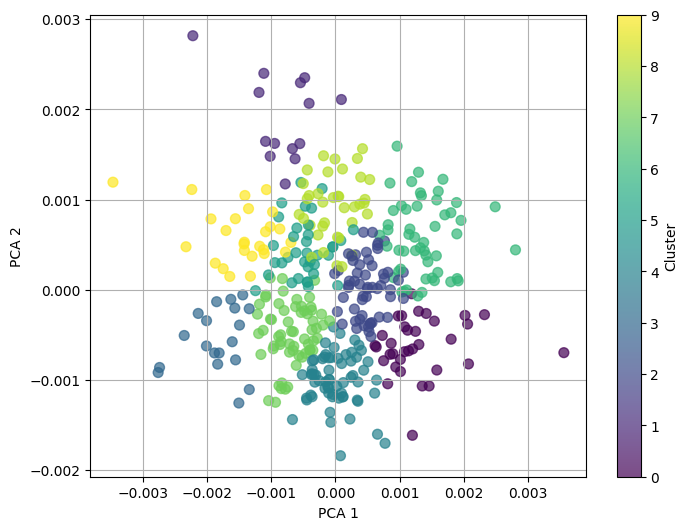

In [119]:
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis', s=50, alpha=0.7)
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.colorbar(label='Cluster')
plt.grid(True)
plt.show()


# Check Results

In [120]:
print(clusters)

[7 0 9 5 4 6 1 7 5 2 4 5 0 4 6 6 4 2 4 0 6 2 4 7 4 3 7 7 9 8 4 5 8 4 8 2 6
 8 7 4 6 0 8 8 1 2 4 8 7 4 0 4 4 9 8 8 4 0 4 7 4 5 4 4 5 0 8 1 7 9 7 2 6 8
 8 9 5 4 7 2 7 9 6 1 2 4 2 8 4 4 5 4 0 3 7 2 7 4 7 3 7 0 4 6 7 7 9 5 2 0 6
 5 0 0 4 4 4 7 4 2 9 6 6 7 9 7 9 5 3 7 0 4 4 0 7 3 7 7 6 5 2 1 5 7 2 8 2 8
 9 4 2 4 5 5 6 0 4 1 2 5 2 0 2 6 8 7 7 1 9 4 3 2 6 6 8 8 7 9 6 7 0 9 5 2 2
 2 3 6 8 6 6 9 9 2 8 6 7 6 3 2 6 6 2 0 8 6 8 3 2 4 4 6 6 2 7 9 3 1 4 0 5 8
 7 1 4 4 5 6 5 6 6 3 6 9 3 7 7 8 3 0 2 1 9 4 7 5 7 2 5 4 9 3 2 7 4 5 8 5 2
 5 4 4 2 6 6 8 8 8 2 6 7 6 2 2 0 1 8 2 8 0 4 7 2 4 2 0 8 4 8 5 2 2 2 2 2 2
 3 0 8 5 0 6 3 9 2 6 0 7 7 2 7 0 6 0 7 7 0 3 0 8 4 6 6 4 7 4 0 6 4 6 5 8 2
 5 2 2 9 6 0 7 7 3 2 6 5 0 7 6 6 3 2 7 5 0 7 7 5 1 7 7 7 4 6 4 5 9 2 2 4 1
 7 4 9 6 9 4 8 5 1 2 4 6 6 7 9 4 4 4 7 4 8 5 7 7 7 2 4 6 5]


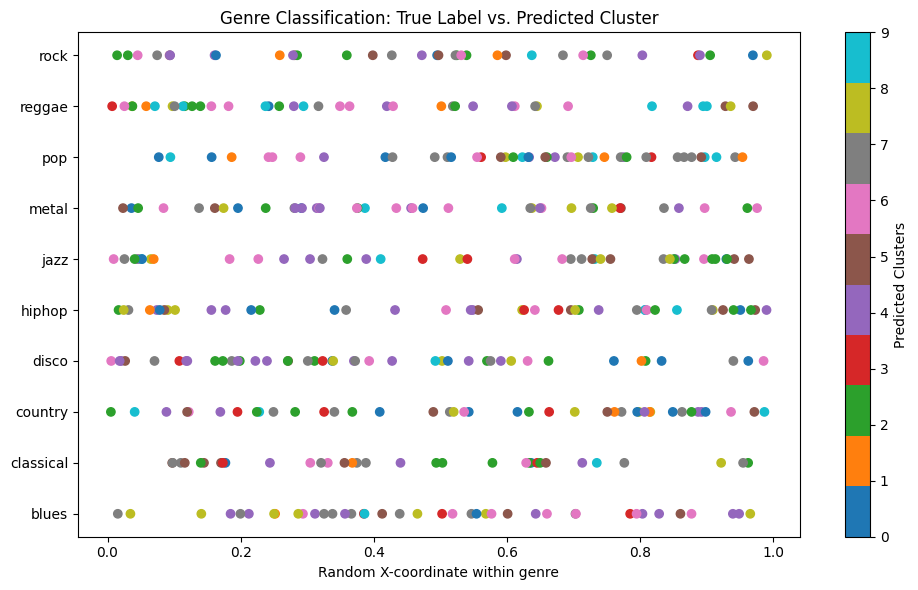

In [121]:
# Create genre list for axis labeling
genres = ['blues','classical','country','disco','hiphop','jazz','metal','pop','reggae','rock']

# Map each true genre to a corresponding y-coordinate
genre_to_y = {genre: i for i, genre in enumerate(genres)}

# Create a plot
plt.figure(figsize=(10, 6))

X= np.random.uniform(0,1, size=len(train_labels))
Y = [genre_to_y[element] for i,element in enumerate(train_labels)]
# Color the points according to predicted cluster
scatter = plt.scatter(X, Y, c=clusters, cmap="tab10" )

# Label the axes
plt.yticks(range(len(genres)), genres)
plt.xlabel("Random X-coordinate within genre")
plt.title("Genre Classification: True Label vs. Predicted Cluster")
plt.colorbar(scatter, label='Predicted Clusters')

# Display legend for the predicted clusters

plt.tight_layout()
plt.show()


In [122]:
# Step 4: Find indices of songs in each cluster
cluster_indices = {}
for cluster_num in range(n_genres): 
    files_in_cluster = [train_labels[i] for i in range(len(clusters)) if clusters[i] == cluster_num]
    cluster_indices[cluster_num] = files_in_cluster

# Step 5: Print the indices for each cluster
for cluster_num, indices in cluster_indices.items():
    print(f"Indices for Cluster {cluster_num}: {indices}")

Indices for Cluster 0: ['hiphop', 'disco', 'metal', 'rock', 'rock', 'metal', 'country', 'disco', 'classical', 'pop', 'jazz', 'hiphop', 'pop', 'disco', 'reggae', 'pop', 'hiphop', 'country', 'country', 'classical', 'disco', 'country', 'metal', 'hiphop', 'jazz', 'pop', 'hiphop', 'disco', 'country', 'pop', 'blues', 'metal', 'country', 'rock']
Indices for Cluster 1: ['reggae', 'rock', 'disco', 'hiphop', 'blues', 'country', 'pop', 'pop', 'classical', 'pop', 'reggae', 'rock', 'jazz', 'country']
Indices for Cluster 2: ['hiphop', 'rock', 'reggae', 'disco', 'disco', 'disco', 'reggae', 'disco', 'metal', 'classical', 'hiphop', 'rock', 'classical', 'rock', 'pop', 'jazz', 'metal', 'country', 'classical', 'hiphop', 'country', 'reggae', 'pop', 'country', 'pop', 'disco', 'country', 'country', 'hiphop', 'hiphop', 'jazz', 'disco', 'classical', 'rock', 'jazz', 'jazz', 'classical', 'metal', 'classical', 'rock', 'reggae', 'hiphop', 'jazz', 'reggae', 'reggae', 'rock', 'disco', 'rock', 'metal', 'jazz', 'disco

In [22]:
for element in cluster_indices[4]:
  print(element)

Chick Corea - Crystal Silence.mp3


# Test

In [19]:
# Load test data from HDF5
import h5py
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset

# Load only test data
mfccs_test = []
mel_test = []
chroma_test = []
tonnetz_test = []

with h5py.File('../genriflow_data/music_features.h5', 'r') as hf:
    test_group = hf['test']
    print("Test songs:", list(test_group.keys()))
    
    for song in test_group:
        mfcc = test_group[song]['mfcc'][:]
        mel = test_group[song]['mel_spectrogram'][:]
        chroma = test_group[song]['chroma'][:]
        tonnetz = test_group[song]['tonnetz'][:]

        # Combine all features along the feature axis (axis=1)
        combined = np.concatenate([mfcc, mel, chroma, tonnetz], axis=1)
        mfccs_test.append(combined)

# Stack into an array
X_test = np.stack(mfccs_test)  # shape: (N, T, F)

# Transpose to shape (N, T, F), crop time dimension if needed
X_test = np.transpose(X_test, (0, 2, 1))  # (N, F, T) → (N, T, F)
X_test = X_test[:, :2000, :]  # Trim to match training input length

print("Test input shape:", X_test.shape)

# Convert to tensor
X_test_tensor = torch.FloatTensor(X_test).to(device)
test_dataset = TensorDataset(X_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)


Test songs: ['Abel Korzeniowski -  Song for the Little Sparrow.mp3', "Adele- Don't You Remember.mp3", 'Adrianne Lenker  -  forwards beckon rebound.mp3', 'Adrianne Lenker - Simulation Swarm.mp3', 'Alanis Morissette - Ironic.mp3', 'Alfa Mist - Organic Rust.mp3', "Aoi Teshima - Teru No Uta Therru's Song.mp3", 'Apparat - Means of entry.mp3', 'Beethoven - Moonlight Sonata 1st Movement.mp3', 'Beverly Glenn-Copeland - Africa Calling.mp3', 'Bliss - Trust In Your Love [Featuring Ane Brun].mp3', 'Bon Iver - 666.mp3', 'Bonobo - Break Apart (feat. Rhye).mp3', 'Bonobo - Heaven For The Sinner feat. Erykah Badu.mp3', 'Bonobo - Pieces Ft Corneila.mp3', 'Chick Corea - Crystal Silence.mp3', 'Coldplay - High Speed.mp3', 'Damien Rice - Amie.mp3', 'David Guetta - Titanium ft. Sia.mp3', 'Erykah Badu - Umm Hmm.mp3', 'Erykah Badu -Honey.mp3', "Fire Emblem Awakening - And what if I can't, what if I'm not worthy of her ideals!.mp3", 'Floating Points, Pharoah Sanders & The London Symphony Orchestra - Promises [M

ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 8 and the array at index 1 has size 32

In [ ]:
# Load model
model = torch.load('lstm_autoencoder.pth', map_location=device)
model.eval()

# Get latent vectors
def get_latent(model, dataloader):
    latent_vectors = []
    with torch.no_grad():
        for batch in dataloader:
            inputs = batch[0]
            _, latent = model(inputs)
            latent_vectors.append(latent.cpu().numpy())
    return np.concatenate(latent_vectors, axis=0)

# Apply KMeans clustering
def perform_kmeans(latent_data, n_clusters=4):
    kmeans = KMeans(
        n_clusters=n_clusters,
        init='k-means++',
        n_init=10,  # Run 10 times with different centroid seeds
        random_state=42
    )
    clusters = kmeans.fit_predict(latent_data)
    return clusters

latent_test = get_latent(model, test_loader)
print("Test latent representations shape:", latent_test.shape)

# Assuming you know or can estimate the number of genres
n_genres = 5  # Adjust this based on your knowledge of the dataset
clusters = perform_kmeans(latent_test, n_clusters=n_genres)

# Step 5: Print the indices for each cluster
for cluster_num, indices in cluster_indices.items():
    print(f"Indices for Cluster {cluster_num}: {indices}")

In [ ]:
for element in cluster_indices[2]:
  print(element)